### Prerequisites

If you don't already have conda installed, [see here and follow step 0][1]

[1]: https://github.com/janelia-flyem/flyemflows/blob/master/docs/flyem-quickstart.md

Then run the following commands from a cluster node.
    
```bash
conda create -n test-dask-image -c conda-forge dask distributed dask-jobqueue z5py jupyterlab matplotlib
conda activate test-dask-image

# Sadly, the latest release does not yet include the distributed
# version of the label() function.
# To get it, we must install from their git repo.
conda install --only-deps -c conda-forge dask-image
git clone https://github.com/dask/dask-image
cd dask-image
python -m pip install --no-deps --ignore-installed .

# Start jupyter-lab
jupyter-lab --ip="0.0.0.0" --no-browser
```


In [1]:
%matplotlib inline

In [2]:
import os
import getpass

import dask
import dask.array as da

import dask_image.ndmeasure
import matplotlib.pyplot as plt

import z5py # Can read N5 and Zarr

# See lsf_cluster_example.py for details
from lsf_cluster_example import init_cluster

#### Create a dask cluster

In [3]:
USER = getpass.getuser()

# See example-dask-config.yaml for more config options.
dask.config.set({'jobqueue':
                    {'lsf':
                      {'processes': 1,
                       'cores': 1,
                       'memory': '15GB',
                       'walltime': '01:00',
                       'log-directory': 'dask-logs',
                       'local-directory': f'/scratch/{USER}',
                       'use-stdin': True
                }}})

# After the cluster starts, it's globally visible
# and all dask workloads will use it.
NUM_CPUS = 2
client = init_cluster(NUM_CPUS)

Waiting for 2 workers...
Waiting for 2 workers...
Waiting for 2 workers...
Waiting for 2 workers...


In [4]:
# Monitor progress via the dashboard link shown below
client

Client Scheduler: tcp://10.36.111.13:45418 Dashboard: http://10.36.111.13:8787/status,Cluster Workers: 2 Cores: 2 Memory: 30.00 GB


#### Create a tiny test volume

In [5]:
def fill_sphere(volume, center, radius, label=1):
    cz, cy, cx = center
    z, y, x = np.indices(volume.shape)
    distances = np.sqrt((z-cz)**2 + (y-cy)**2 + (x-cx)**2)
    volume[(distances < radius)] = label

shape = np.array([128, 256, 256])
dtype = np.uint8
vol = np.zeros(shape, dtype)
fill_sphere(vol, (64,64,64), 20)
fill_sphere(vol, (64,192,192), 20)

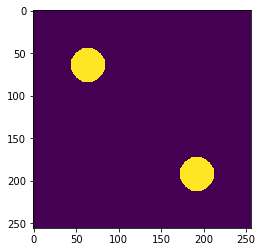

In [6]:
# Show the middle slice
plt.imshow(vol[64]);

#### Save as N5

In [7]:
n5_path = os.environ['HOME'] + '/test.n5'
CHUNKS = (64,64,64)
with z5py.File(n5_path, 'w') as f:
    f.create_dataset('fake-organelles', data=vol, chunks=CHUNKS)

#### Create a dask-array that will be loaded from the N5 volume

In [8]:
def read_block(_orig, block_info):
    slicing = tuple(slice(a,b) for a,b in block_info[None]['array-location'])
    with z5py.File(n5_path, 'r') as f:
        return f['fake-organelles'][slicing]

dset = z5py.File(n5_path, 'r')['fake-organelles']
arr = da.empty_like(dset, chunks=CHUNKS).map_blocks(read_block, meta={'dtype': dtype})

#### Label the connected components

In [9]:
labeled, num_labels = dask_image.ndmeasure.label(arr)
labeled = labeled.compute()

#### Check a slice of the results

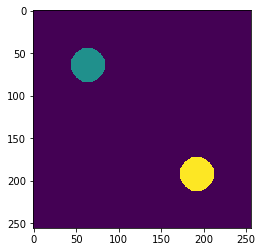

In [10]:
# If the data has been labeled as expected,
# we'll see different colors below.
plt.imshow(labeled[64]);

#### Shut down the cluster when you're done.

In [11]:
client.cluster.close()
client.close()